# Compare $W(k, k^{\prime}) \times P_{\mathrm{cubic}}(k^{\prime})$ and $P_{\mathrm{cutsky}}(k)$ to validate window computation after sculpting-window transformation

In [1]:
import os
import sys

import numpy as np
from matplotlib import pyplot as plt

from desilike.samples import Profiles

sys.path.append('../bin')
from utils import load_poles, load_poles_list
from cov_utils import truncate_cov
from desi_file_manager import DESIFileName
from local_file_manager import LocalFileName
from sculpt_window import SculptWindow

from pypower import PowerSpectrumSmoothWindowMatrix

# plotting
plt.style.use(os.path.join(os.path.abspath('../bin'), 'plot_style.mplstyle'))
plots_dir = '../../plots/'

### Global parameters

In [2]:
# official desi ('desi') or locally ('local') generated window/pk
source = 'desi'

# mocks/version
catalog = 'second'
version = 'v3'
imocks = range(25)

# tracer
tracer = 'ELG_LOP'
region = 'SGC'
completeness = True
zrange = (0.8, 1.6)

# multipoles
ells = (0, 2, 4)
ktmax = 0.5
krange = (0.02, 0.2, 0.005)

# cut
rpcut = 0.
thetacut = 0.05

## $P_{\mathrm{cubic}}(k)$

In [3]:
fn = LocalFileName()
fn.set_default_config(mockgen='cubic', tracer=tracer)
cubic_pk = load_poles_list([fn.get_path(realization=imock, los=los) for los in ('xyz') for imock in range(25)])

### Model fitted on $P_{\mathrm{cubic}}(k)$

In [4]:
data_dir = '/global/cfs/cdirs/desi/users/mpinon/cubicSecondGenMocks/'

template_name = 'shapefitqisoqap'

emulator_dir = os.path.join(data_dir, 'emulators/test/emulators_{}_ELG'.format(template_name))
profiles_dir = os.path.join(data_dir, 'profiles/cubicsecondgenmocks/profiles_{}_ELG_complete'.format(template_name))
profile_cubic = Profiles.load(os.path.join(profiles_dir, 'power_velocileptors.npy'))

## Window matrix $W^{\prime}(k, k^{\prime})$

In [5]:
fdir = "/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/{}/sculpt_window".format(version)

sculptwm_fn = LocalFileName().set_default_config(ftype='sculpt_all', tracer=tracer, region=region, completeness=completeness, realization=None, rpcut=rpcut, thetacut=thetacut)
sculptwm_fn.update(fdir=fdir, zrange=zrange, cellsize=None, boxsize=None, directedges=False)
sculptwm = SculptWindow.load(sculptwm_fn.get_path())

wm = sculptwm.wmatrixnew
koutrebin = 1
wm.slice_x(sliceout=slice(0, len(wm.xout[0]) // koutrebin * koutrebin, koutrebin))
wm.select_x(xoutlim=(krange[0], krange[1]))
kinrebin = 10
wm.slice_x(slicein=slice(0, len(wm.xin[0]) // kinrebin * kinrebin, kinrebin))
wm.select_x(xinlim=(0.005, ktmax))

mmatrix = sculptwm.mmatrix
mo = sculptwm.mo
cov = sculptwm.covnew
cov = truncate_cov(cov, kinit=np.arange(0., 0.4, 0.005), kfinal=np.arange(*krange))
stdY1 = np.sqrt(np.diag(cov)).reshape((3, len(cov[0])//3))

### Theory from fitted $P_{\mathrm{cubic}}(k)$

In [6]:
from emulator_fit import get_fit_setup, get_template
from desilike.theories.galaxy_clustering import LPTVelocileptorsTracerPowerSpectrumMultipoles

z, b0, klim, slim = get_fit_setup(tracer=tracer, theory_name='velocileptors')
for lim in klim.values():
    lim = krange
from cosmoprimo.fiducial import DESI
fiducial = DESI()
b1E = b0 / fiducial.growth_factor(z)

template = get_template(template_name=template_name, z=z)

theory = LPTVelocileptorsTracerPowerSpectrumMultipoles(template=template, ells=klim.keys(), k=wm.xin[0])
pk_theory = theory(**profile_cubic.bestfit.choice(input=True))

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20231013-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


### $W^{\prime}(k, k^{\prime}) \times P_{\mathrm{theory}}(k^{\prime})$

In [7]:
wm_pk = (wm.value.T.dot(pk_theory.flatten())).reshape((len(ells), wm.shape[1]//len(ells)))

## $P^{\prime}_{\mathrm{cutsky}}(k)$

In [8]:
if source == 'desi':
    fn = DESIFileName()
    fn.set_default_config(version=version, tracer=tracer, region=region, completeness=completeness)
elif source == 'local':
    fn = LocalFileName()
    fn.set_default_config(mockgen=catalog, tracer=tracer, region=region, completeness=completeness)
    fn.update(cellsize=6)
    
cutsky_pk = load_poles_list([fn.get_path(realization=imock, rpcut=rpcut, thetacut=thetacut) for imock in range(25)], xlim={ell: (0, 0.4, 0.005) for ell in ells})
# New Pk
cutsky_pk_new = np.matmul(mmatrix, cutsky_pk['data'].flatten()).reshape((len(ells), len(cutsky_pk['data'].flatten())//len(ells)))

In [9]:
fn.get_path()

'/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/desipipe/v3/complete/baseline_2pt/mock24/pk/pkpoles_ELG_LOP_SGC_z0.8-1.6_thetacut0.05.npy'

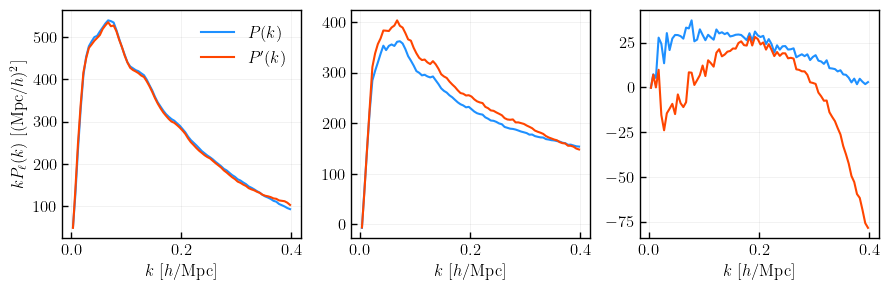

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=False, sharex=True)

for ill, ell in enumerate(ells):
    axes[ill].plot(cutsky_pk['k'][ill], cutsky_pk['k'][ill] * cutsky_pk['data'][ill], color='C0', linestyle='-', label=r'$P(k)$')
    axes[ill].plot(cutsky_pk['k'][ill], cutsky_pk['k'][ill] * cutsky_pk_new[ill], color='C1', linestyle='-', label=r'$P^{\prime}(k)$')
    axes[ill].set_xlabel(r'$k$ [$h$/Mpc]')
    
axes[0].set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[0].legend()
#plt.savefig(os.path.join(plots_dir, 'secondgenmocks_ELG_LOP_SGC_0.8_1.6{}_pknew_pk.png'.format('_rpcut{}'.format(rp_cut) if rp_cut else '')), dpi=300)
plt.show()

In [11]:
mask = (np.arange(0, 0.4, 0.005) >= krange[0]) & (np.arange(0, 0.4, 0.005) < krange[1])
cutsky_pk_new = cutsky_pk_new[:, mask]

### Model fitted on $P^{\prime}_{\mathrm{cutsky}}(k)$

In [12]:
data_dir = '/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/{}'.format(version)

template_name = 'shapefitqisoqap'

if rpcut:
    cutflag = '_rpcut{:.1f}'.format(rpcut)
elif thetacut:
    cutflag = '_thetacut{:.2f}'.format(thetacut)
else:
    cutflag = ''

emulator_dir = os.path.join(data_dir, 'emulators/emulators_{}_ELG_LOP'.format(template_name))
footprint_fn=os.path.join(data_dir, 'footprints', 'footprint_{}{}.npy')
profiles_dir = os.path.join(data_dir, 'profiles', 'profiles_{}_ELG_LOP_complete_SGC'.format(template_name))
profile_cutsky = Profiles.load(os.path.join(profiles_dir, 'power_velocileptors{}_sculptwindow_fixedsn.npy'.format(cutflag)))

In [13]:
from emulator_fit import get_power_likelihood

likelihood = get_power_likelihood(source=source, catalog=catalog, version=version, tracer=tracer, region=region, completeness=completeness, solve=False, rp_cut=rpcut, theta_cut=thetacut, sculpt_window=True, emulator_fn=os.path.join(emulator_dir, 'power_{}.npy'), footprint_fn=footprint_fn)

likelihood.solved_default = '.best'
likelihood(**profile_cutsky.bestfit.choice(input=True))
cutsky_obs = likelihood.observables[0]
pk_obs = cutsky_obs.theory

NameError: name 'wmatrix_fn' is not defined

In [ ]:
print(profile_cutsky.bestfit['syst_0'][0])
print(profile_cutsky.bestfit['syst_1'])
print(profile_cutsky.bestfit['syst_2'])

## Plot

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(10, 4), sharey=False, sharex=True, gridspec_kw={'height_ratios': [4, 2]})

for ill, ell in enumerate(ells):
    axes[0][ill].errorbar(cutsky_pk['k'][ill][mask], cutsky_pk['k'][ill][mask] * cutsky_pk_new[ill], cutsky_pk['k'][ill][mask]*stdY1[ill]/5, color='C{}'.format(ill), marker='.', ls='', label=r'$P^{\prime}(k)$')
    axes[0][ill].plot(cutsky_obs.k[ill], cutsky_obs.k[ill] * cutsky_obs.theory[ill], color='C{:d}'.format(ill), linestyle='-', label=r'fit')
    axes[0][ill].set_title(r'$\ell={}$'.format(ell))
    
    axes[1][ill].plot(cutsky_pk['k'][ill][mask], (cutsky_obs.theory[ill] - cutsky_pk_new[ill])/stdY1[ill], color='C{}'.format(ill))
    axes[1][ill].set_xlabel(r'$k$ [$h$/Mpc]')
    
axes[0][0].set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel(r'$\Delta P_{\ell}(k) / \sigma$')
axes[0][0].legend()
fig.align_ylabels()
plt.show()

In [ ]:
mask_flat = np.concatenate((mask, )*len(ells))

In [ ]:
def chi2(m):
    nells = wm_pk.shape[0]
    r = wm_pk - cutsky_pk_new + (m.dot(mo[:, mask_flat])).reshape(wm_pk.shape)
    chisq = np.sum(r**2 / stdY1**2)
    return chisq

from scipy.optimize import minimize

minimizer = minimize(chi2, x0=np.array([1, 1, 1]))
print(minimizer)

In [ ]:
m = minimizer.x

In [ ]:
m = np.array([profile_cutsky.bestfit['syst_{}'.format(i)][0] for i in range(len(ells))])

mmo = (m.dot(mo[:, mask_flat])).reshape(wm_pk.shape)

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(10, 4), sharey=False, sharex=True, gridspec_kw={'height_ratios': [4, 2]})

for ill, ell in enumerate(ells):
    axes[0][ill].errorbar(cutsky_pk['k'][ill][mask], cutsky_pk['k'][ill][mask] * cutsky_pk_new[ill], cutsky_pk['k'][ill][mask]*stdY1[ill]/5, color='C{}'.format(ill), marker='.', ls='', label=r'$P^{\prime}(k)$')
    axes[0][ill].plot(wm.xout[ill], wm.xout[ill] * (wm_pk[ill] + mmo[ill]), color='C{}'.format(ill), label=r'$W^{\prime}(k, k^{\prime}) P^{\prime}_{\mathrm{th}}(k^{\prime})$')
    axes[0][ill].set_title(r'$\ell={}$'.format(ell))
    
    axes[1][ill].plot(wm.xout[ill], (wm_pk[ill] + mmo[ill] - cutsky_pk_new[ill])/stdY1[ill], color='C{}'.format(ill))
    axes[1][ill].set_xlabel(r'$k$ [$h$/Mpc]')
    
axes[0][0].set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel(r'$\Delta P_{\ell}(k) / \sigma$')
axes[0][0].legend()
fig.align_ylabels()
plt.savefig(os.path.join(plots_dir, version, 'window_sculpt_validation_{}mocks{}_{}cut{:.2f}_{}_{}_ktmax{}.pdf'.format(len(imocks), '_complete' if completeness else '_fa', 'rp' if rpcut else 'theta', max(rpcut, thetacut), tracer, region, ktmax)), dpi=200)
plt.show()